In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(f"{recent_date[0]}")

2017-08-23


In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_data = dt.datetime.strptime(recent_date[0], '%Y-%m-%d')
query1 = dt.date(recent_data.year, recent_data.month, recent_data.day)
query1

datetime.date(2017, 8, 23)

In [11]:
# Calculate the date one year from the last date in data set.
query2 = dt.date(query1.year -1, query1.month, query1.day)
query2

datetime.date(2016, 8, 23)

In [12]:
# Perform a query to retrieve the data and precipitation scores
sel1 = [measurement.date,measurement.prcp]
query_result1 = session.query(*sel1).filter(measurement.date >= query2)
query_result1

In [13]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
Inches = pd.DataFrame(query_result1, columns=['Date','Precipitation'])
Inches.head()

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [14]:
# Sort the dataframe by date
Inches = Inches.dropna(how='any')
Inches = Inches.sort_values(["Date"], ascending=True)
Inches.head()

,Date,Precipitation
0,2016-08-23,0.00
1192,2016-08-23,0.02
704,2016-08-23,0.05
1881,2016-08-23,0.70
361,2016-08-23,0.15


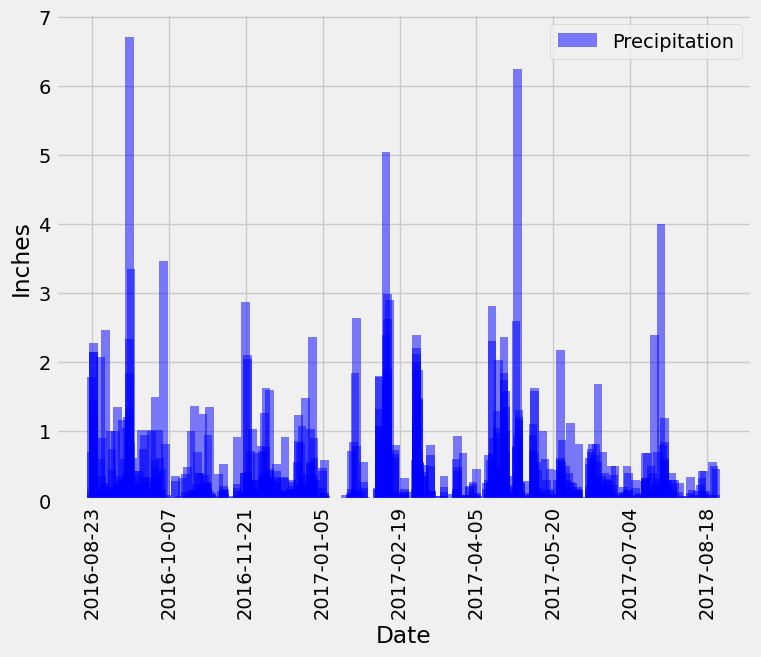

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
x_axis = Inches.Date.tolist()
y_axis = Inches['Precipitation'].tolist()

plt.figure(figsize=(8,6))
plt.bar(x_axis,y_axis,width = 5 ,color='blue', alpha=0.5, align="center",label='Precipitation')
major_ticks = np.arange(0,400,45)
plt.xticks(major_ticks, rotation='vertical')

plt.xlabel("Date")
plt.ylabel("Inches")
plt.grid(which='major', axis='both', linestyle='-')
plt.legend()
plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
Inches.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
session.query(station.id).count()

9

In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel2 = [measurement.station,func.count(measurement.id)]
mostactivestations = session.query(*sel2).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).all()
mostactivestations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
sel3 = [func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)]
mostactivestationstemps = session.query(*sel3).\
    filter(measurement.station == mostactivestations[0][0]).all()
mostactivestationstemps

[(54.0, 85.0, 71.66378066378067)]

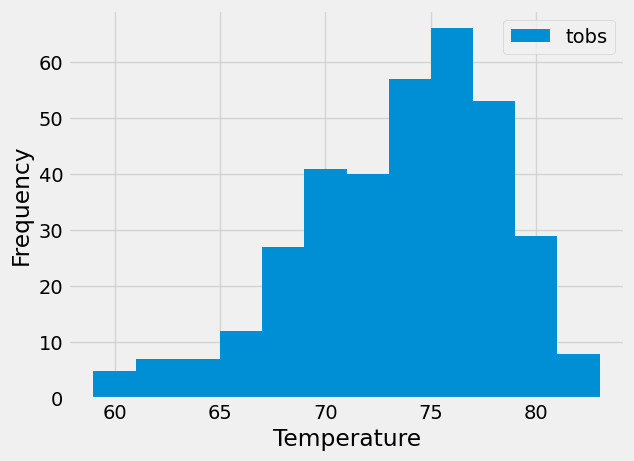

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query_result2 = session.query(measurement.tobs).\
    filter(measurement.station == mostactivestations[0][0]).\
    filter(measurement.date >= query2).all()
Temperature = list(np.ravel(query_result2))

sel4 = [station.station,station.name,station.latitude,station.longitude,station.elevation]
query_result3 = session.query(*sel4).all()
stations_df = pd.DataFrame(query_result3, columns=['Station','Name','Latitude','Longitude','Elevation'])

plt.hist(Temperature, bins=12,rwidth=1.0,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Close Session

In [21]:
# Close Session
session.close()